# Model using the Naive Bayes Classifier

In [168]:
# code based on https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier

import re, string, random

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

if __name__ == "__main__":

    positive_tweets = twitter_samples.strings('positive_tweets.json')
    negative_tweets = twitter_samples.strings('negative_tweets.json')
    text = twitter_samples.strings('tweets.20150430-223406.json')
    tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

    stop_words = stopwords.words('english')

    positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
    negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

    positive_cleaned_tokens_list = []
    negative_cleaned_tokens_list = []

    for tokens in positive_tweet_tokens:
        positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    for tokens in negative_tweet_tokens:
        negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    all_pos_words = get_all_words(positive_cleaned_tokens_list)

    freq_dist_pos = FreqDist(all_pos_words)
    #print(freq_dist_pos.most_common(10))

    positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
    negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

    positive_dataset = [(tweet_dict, "Positive")
                         for tweet_dict in positive_tokens_for_model]

    negative_dataset = [(tweet_dict, "Negative")
                         for tweet_dict in negative_tokens_for_model]

    dataset = positive_dataset + negative_dataset

    random.shuffle(dataset)

    train_data = dataset[:7000]
    test_data = dataset[7000:]

    classifier = NaiveBayesClassifier.train(train_data)

    print("Accuracy is:", classify.accuracy(classifier, test_data))

    #print(classifier.show_most_informative_features(10))


Accuracy is: 0.9966666666666667


## SentimentCalculation using the NB classifier making the diagrams showing postive and negative text in artist tweets and lyrics

In [166]:
import json
import pandas as pd
import matplotlib as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)



def sentenceSentiment(sentence):
    
    custom_tokens= remove_noise(word_tokenize(sentence))
    result = classifier.classify(dict([token, True] for token in custom_tokens))
    #print(sentence, " : ", result)
    return result


def multiplesentenceSentiment(artist):
    pos = 0
    neg = 0
    f = open(artist+'.json', 'rb')
    num_words = 0
    all_text = ''
    for sentence in f.readlines():
        this_sentence = sentence.decode('utf-8')
        if sentenceSentiment(this_sentence) == "Positive":
            pos+=1
        elif sentenceSentiment(this_sentence) == "Negative":
            neg+=1
    print(artist, "Pos: ", pos, "Neg: ", neg)
    df = pd.DataFrame({artist: [pos, neg]},
                  index=['Positive', 'Negative'])
    plot = df.plot.pie(y=artist, figsize=(5, 5))
    
def sentimentWithNBC():
    p = 0
    for artist in artists:
        multiplesentenceSentiment(artist)
        multiplesentenceSentiment(accounts[p]+'-tweets')
        p+=1

### Execution of the sentiment analysis using the NB classifier

runthejewels Pos:  120 Neg:  283
KillerMike-tweets Pos:  107 Neg:  134
justintimberlake Pos:  224 Neg:  308
jtimberlake-tweets Pos:  124 Neg:  154
theblackeyedpeas Pos:  175 Neg:  310
bep-tweets Pos:  164 Neg:  82
cher Pos:  75 Neg:  198
cher-tweets Pos:  119 Neg:  203
aboogiewitdahoodie Pos:  86 Neg:  281
ArtistHBTL-tweets Pos:  119 Neg:  212


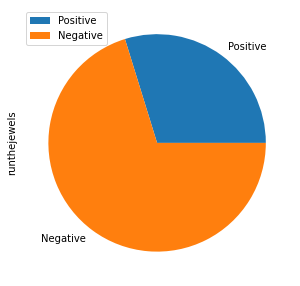

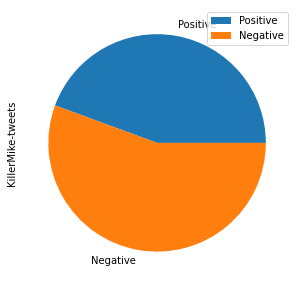

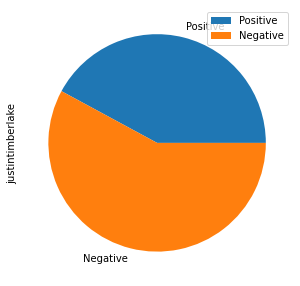

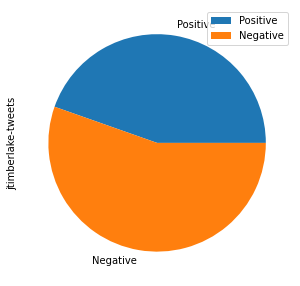

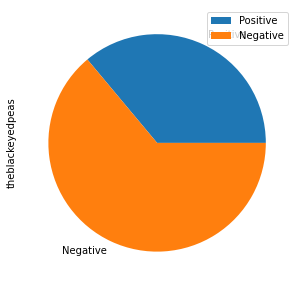

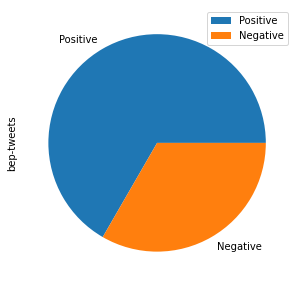

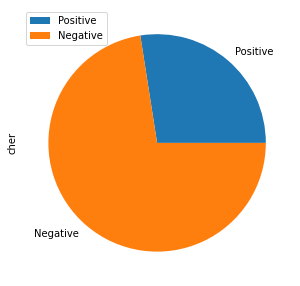

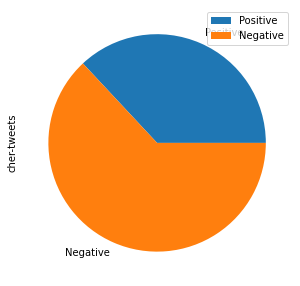

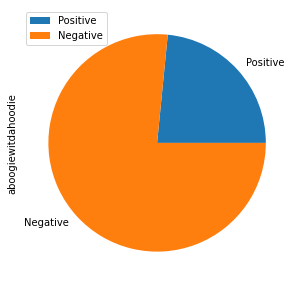

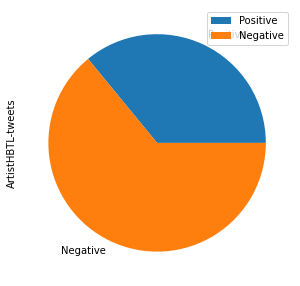

In [167]:
sentimentWithNBC()


# A list of all artists and their twitter handles
### Artist/band name in same order as lists below:
    Killer Mike from Run The Jewels
    Justin Timberlake
    The Black Eyed Peas
    Cher
    A Boogie wit da Hoodie

In [41]:
artists = ["runthejewels", "justintimberlake", "theblackeyedpeas", "cher", "aboogiewitdahoodie"]
accounts = ["KillerMike","jtimberlake", "bep", "cher", "ArtistHBTL"]


# Code for the VADER Sentiment Intensity Analyzer

Also plots two tables and associated diagrams, one for lyrics and one for tweets

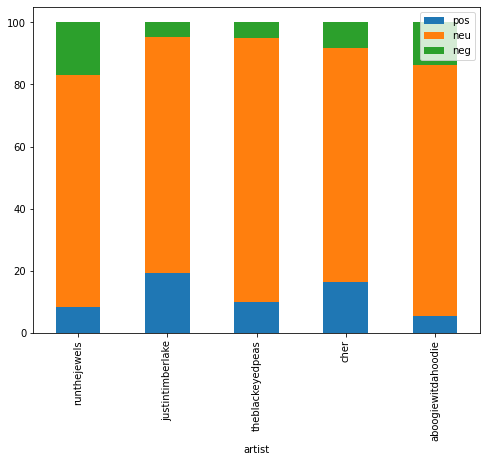

               Artist   positive    neutral   negative
0        runthejewels   8.436725  74.441687  17.121588
1    justintimberlake  19.172932  75.939850   4.887218
2    theblackeyedpeas  10.103093  84.742268   5.154639
3                cher  16.483516  75.091575   8.424908
4  aboogiewitdahoodie   5.449591  80.653951  13.896458


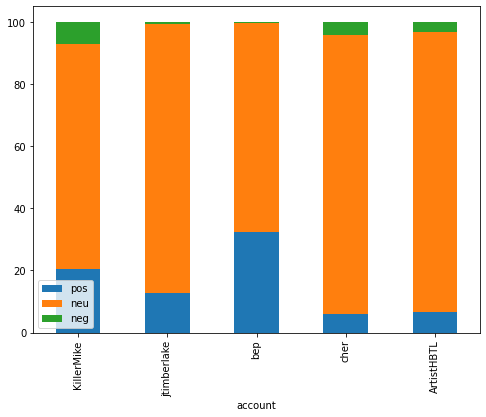

In [171]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

def plotLyrics():
    pos = []
    neg = []
    neu = []
    
    df = pd.DataFrame(columns=('artist', 'pos', 'neu', 'neg'))
    sid = SentimentIntensityAnalyzer()
    i=0
    for artist in artists:
        num_positive = 0
        num_negative = 0
        num_neutral = 0

        f = open(artist+'.json', 'rb')
        for sentence in f.readlines():
            this_sentence = sentence.decode('utf-8')
            comp = sid.polarity_scores(this_sentence)
            comp = comp['compound']
            if comp >= 0.5:
                num_positive += 1
            elif comp > -0.5 and comp < 0.5:
                num_neutral += 1
            else:
                num_negative += 1

        num_total = num_negative + num_neutral + num_positive
        percent_negative = (num_negative/float(num_total))*100
        percent_neutral = (num_neutral/float(num_total))*100
        percent_positive = (num_positive/float(num_total))*100
        df.loc[i] = (artist, percent_positive, percent_neutral, percent_negative)
        i+=1
        neg.append(percent_negative)
        pos.append(percent_positive)
        neu.append(percent_neutral)
        
    df.plot.bar(x='artist', stacked=True)
    plt.show()
    tabledata = {'Artist': artists,
             'positive': pos,
             'neutral': neu,
             'negative': neg
            }

    percentagedata = pd.DataFrame(tabledata)

    print(percentagedata)



def plotTweets():
    pos = []
    neg = []
    neu = []
    
    df2 = pd.DataFrame(columns=('account', 'pos', 'neu', 'neg'))
    sid2 = SentimentIntensityAnalyzer()
    i=0
    for account in accounts:
        num_positive = 0
        num_negative = 0
        num_neutral = 0

        f = open(account+'-tweets.json', 'rb')
        for sentence in f.readlines():
            this_sentence = sentence.decode('utf-8')
            comp = sid.polarity_scores(this_sentence)
            comp = comp['compound']
            if comp >= 0.5:
                num_positive += 1
            elif comp > -0.5 and comp < 0.5:
                num_neutral += 1
            else:
                num_negative += 1

        num_total = num_negative + num_neutral + num_positive
        percent_negative = (num_negative/float(num_total))*100
        percent_neutral = (num_neutral/float(num_total))*100
        percent_positive = (num_positive/float(num_total))*100
        df2.loc[i] = (account, percent_positive, percent_neutral, percent_negative)
        i+=1
        neg.append(percent_negative)
        pos.append(percent_positive)
        neu.append(percent_neutral)


    df2.plot.bar(x='account', stacked=True)
    plt.show()


    tabledata = {'Account': artists,
                 'positive': pos,
                 'neutral': neu,
                 'negative': neg
                }

    percentagedata = pd.DataFrame(tabledata)
    
    percentagedata.head()

plotLyrics()
plotTweets()

# Code for extracting tweets and writing them to separate files

In [124]:
# Extract tweets from artists and add them to their seperate json file
# Code is based on https://www.geeksforgeeks.org/extraction-of-tweets-using-tweepy/
import tweepy
import json
import sys
import re

#Twitter API credentials
consumer_key = "QT71wWa3Q5DsZpvoBXgePWDEo"
consumer_secret = "Thld0v7deTtjSLNbLkt8HuCltHixGyaX2hX2NLtqHOlzdh5deQ"
access_key = "2381011026-GO6kNoyHpZacdwXWjKrwLJQImXHmIJg16LNagmo"
access_secret = "lwr43LEqFwkOq7O6QnuhvPDGpGMeGSUjASMM2FAU6pEX0"


def get_tweets(username): 
          
        # Authorization to consumer key and consumer secret 
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
  
        # Access to user's access key and access secret 
        auth.set_access_token(access_key, access_secret) 
  
        # Calling api 
        api = tweepy.API(auth) 
  
        # variable for number of tweets to be extracted 
        number_of_tweets=500
        tweets = api.user_timeline(screen_name=username, count = number_of_tweets) 
  
        # Empty Array 
        tmp=[]
        

  
        # create array of tweet information: username,  
        # tweet id, date/time, text 
        tweets_for_csv = [tweet.text for tweet in tweets] # CSV file created  
        for j in tweets_for_csv:
            new = re.sub(r"RT|@\S+|http\S+", "", j) # a regex for removing urls, 'RT' string from retweets and mentions
            # Appending tweets to the empty array tmp 
            tmp.append(new)

        
        with open(username+'-tweets.json','w', encoding='utf-8') as f:
            f.write('\n'.join(tmp))

        
        

  
  
# Driver code 
if __name__ == '__main__': 
  
    # twitter handle and artist/band name
    get_tweets("bep") # BlackEyedPeas
    get_tweets("KillerMike") #Killer Mike from Run The Jewsel
    get_tweets("jtimberlake") # Justin timberlake
    get_tweets("ArtistHBTL") # A Boogie wit da Hoodie
    get_tweets("cher") # Cher
    